In [214]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[1] "playground-series-s5e2"

# **Import**
---------

In [215]:
library(tidymodels)
library(tidyverse)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(psych)
library(ggcorrplot)

# **1. Data Import & EDA**
------------

In [216]:
train <- read.csv('/kaggle/input/playground-series-s5e2/train.csv', row.names= 1) 
test <- read.csv('/kaggle/input/playground-series-s5e2/test.csv') 
submit <- read.csv('/kaggle/input/playground-series-s5e2/sample_submission.csv')
train_extra <- read.csv('/kaggle/input/playground-series-s5e2/training_extra.csv', row.names= 1)

## **Data Description**
-----------------
* **id**	:	Unique identifier for each backpack.
* **Brand**	:	The brand of the backpack (e.g., Nike, Adidas, Jansport).
* **Material**	:	The primary material used for the backpack (e.g., Leather, Canvas, Nylon, Polyester).
* **Size**	:	The size category of the backpack (e.g., Small, Medium, Large).
* **Compartments**	:	The number of compartments available in the backpack.
* **Laptop.Compartment**	:	Indicates whether the backpack has a dedicated laptop compartment (Yes or No).
* **Waterproof**	:	Indicates whether the backpack is waterproof (Yes or No).
* **Style**	:	The style of the backpack (e.g., Backpack, Messenger, Tote).
* **Color**	:	The primary color of the backpack.
* **Weight.Capacity..kg.**	:	The maximum weight the backpack can carry in kilograms.
* **Price**	:	The price of the backpack in currency units.


In [217]:
train <- rbind(train, train_extra)

## **Summary**

In [218]:
str(train)

'data.frame':	3994318 obs. of  10 variables:
 $ Brand               : chr  "Jansport" "Jansport" "Under Armour" "Nike" ...
 $ Material            : chr  "Leather" "Canvas" "Leather" "Nylon" ...
 $ Size                : chr  "Medium" "Small" "Small" "Small" ...
 $ Compartments        : num  7 10 2 8 1 10 3 1 8 2 ...
 $ Laptop.Compartment  : chr  "Yes" "Yes" "Yes" "Yes" ...
 $ Waterproof          : chr  "No" "Yes" "No" "No" ...
 $ Style               : chr  "Tote" "Messenger" "Messenger" "Messenger" ...
 $ Color               : chr  "Black" "Green" "Red" "Green" ...
 $ Weight.Capacity..kg.: num  11.6 27.1 16.6 12.9 17.7 ...
 $ Price               : num  112.2 68.9 39.2 80.6 86 ...


In [219]:
str(test)

'data.frame':	200000 obs. of  10 variables:
 $ id                  : int  300000 300001 300002 300003 300004 300005 300006 300007 300008 300009 ...
 $ Brand               : chr  "Puma" "Nike" "Adidas" "Adidas" ...
 $ Material            : chr  "Leather" "Canvas" "Canvas" "Nylon" ...
 $ Size                : chr  "Small" "Medium" "Large" "Large" ...
 $ Compartments        : num  2 7 9 1 2 8 8 6 8 1 ...
 $ Laptop.Compartment  : chr  "No" "No" "No" "Yes" ...
 $ Waterproof          : chr  "No" "Yes" "Yes" "No" ...
 $ Style               : chr  "Tote" "Backpack" "Messenger" "Messenger" ...
 $ Color               : chr  "Green" "Green" "Blue" "Green" ...
 $ Weight.Capacity..kg.: num  20.67 13.56 11.81 18.48 9.91 ...


In [220]:
skim_ <- skimr::skim(train)
print(skim_)

── Data Summary ────────────────────────
                           Values 
Name                       train  
Number of rows             3994318
Number of columns          10     
_______________________           
Column type frequency:            
  character                7      
  numeric                  3      
________________________          
Group variables            None   

── Variable type: character ────────────────────────────────────────────────────
  skim_variable      n_missing complete_rate min max  empty n_unique whitespace
1 Brand                      0             1   0  12 126758        6          0
2 Material                   0             1   0   9 110962        5          0
3 Size                       0             1   0   6  87785        4          0
4 Laptop.Compartment         0             1   0   3  98533        3          0
5 Waterproof                 0             1   0   3  94324        3          0
6 Style                      0             1   

**Checking Missing Value & Duplicate Value**

In [221]:
na <- data.frame(NaN_Count = colSums(is.na(train)))
na

,NaN_Count
,<dbl>
Brand,0
Material,0
Size,0
Compartments,0
Laptop.Compartment,0
Waterproof,0
Style,0
Color,0
Weight.Capacity..kg.,1808


In [222]:
sum(duplicated(train))

[1] 0

In [223]:
head(train)

,Brand,Material,Size,Compartments,Laptop.Compartment,Waterproof,Style,Color,Weight.Capacity..kg.,Price
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
0,Jansport,Leather,Medium,7,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1,Yes,Yes,Messenger,Green,17.749338,86.02312
5,Nike,Canvas,Medium,10,No,Yes,,Black,7.241812,20.01553


# **2. Data Transformation**
----------

In [224]:
#Rename
train <- train %>% rename(Weight = Weight.Capacity..kg.)
test <- test %>% rename(Weight = Weight.Capacity..kg.)

In [225]:
#Select numeric cols 
num_cols <- {}
for(i in 1:length(train)){
    if(is.numeric(train[[i]]) == T)
        num_cols <- c(num_cols ,colnames(train[i]))
}

#Select categorical cols 
cat_cols <- {}
for(i in 1:length(train)){
    if(is.character(train[[i]]) == T)
        cat_cols <- c(cat_cols ,colnames(train[i]))
}

In [226]:
cat('Numeric columns:',num_cols,'\nCategorical columns:',cat_cols)

Numeric columns: Compartments Weight Price 
Categorical columns: Brand Material Size Laptop.Compartment Waterproof Style Color

In [227]:
#Update Data types (char -> factor)
train <- train %>% mutate(across(
    c(
        where(is.character)
     ),
    ~as.factor(.x)
    ))

test <- test %>% mutate(across(
    c(
        where(is.character)
     ),
    ~as.factor(.x)
    ))

In [228]:
#Filling Missing Values (Replace with the median)

train <- train %>%
  mutate(Weight = ifelse(is.na(Weight), median(Weight, na.rm = TRUE), Weight)) 

test <- test %>%
  mutate(Weight = ifelse(is.na(Weight), median(Weight, na.rm = TRUE), Weight)) 

In [229]:
#Filling Missing Values (Replace with the mode)

filling_mode <- function(x){
        frequency <- table(x)
        mode <- names(frequency)[which.max(frequency)] 
        return(mode)
}

train$Brand[train$Brand == ''] <- NA
train$Material[train$Material == ''] <- NA
train$Size[train$Size == ''] <- NA
train$Style[train$Style == ''] <- NA
train$Color[train$Color == ''] <- NA
train$Laptop.Compartment[train$Laptop.Compartment == ''] <- NA
train$Waterproof[train$Waterproof == ''] <- NA

train$Brand[is.na(train$Brand)] <- filling_mode(train$Brand)
train$Material[is.na(train$Material)] <- filling_mode(train$Material)
train$Size[is.na(train$Size)] <- filling_mode(train$Size)
train$Style[is.na(train$Style)] <- filling_mode(train$Style)
train$Color[is.na(train$Color)] <- filling_mode(train$Color)
train$Laptop.Compartment[is.na(train$Laptop.Compartment)] <- filling_mode(train$Laptop.Compartment)
train$Waterproof[is.na(train$Waterproof)] <- filling_mode(train$Waterproof)

In [230]:
#Filling Missing Values (Replace with the mode)

test$Brand[test$Brand == ''] <- NA
test$Material[test$Material == ''] <- NA
test$Size[test$Size == ''] <- NA
test$Style[test$Style == ''] <- NA
test$Color[test$Color == ''] <- NA
test$Laptop.Compartment[test$Laptop.Compartment == ''] <- NA
test$Color[test$Color == ''] <- NA

test$Brand[is.na(test$Brand)] <- filling_mode(test$Brand)
test$Material[is.na(test$Material)] <- filling_mode(test$Material)
test$Size[is.na(test$Size)] <- filling_mode(test$Size)
test$Style[is.na(test$Style)] <- filling_mode(test$Style)
test$Color[is.na(test$Color)] <- filling_mode(test$Color)
test$Laptop.Compartment[is.na(test$Laptop.Compartment)] <- filling_mode(test$Laptop.Compartment)
test$Waterproof[is.na(test$Waterproof)] <- filling_mode(test$Waterproof)

# **3. Data Visulization**

* **Using Train Data Set**

## **Histogram & Boxplot & Densityplot**

---------

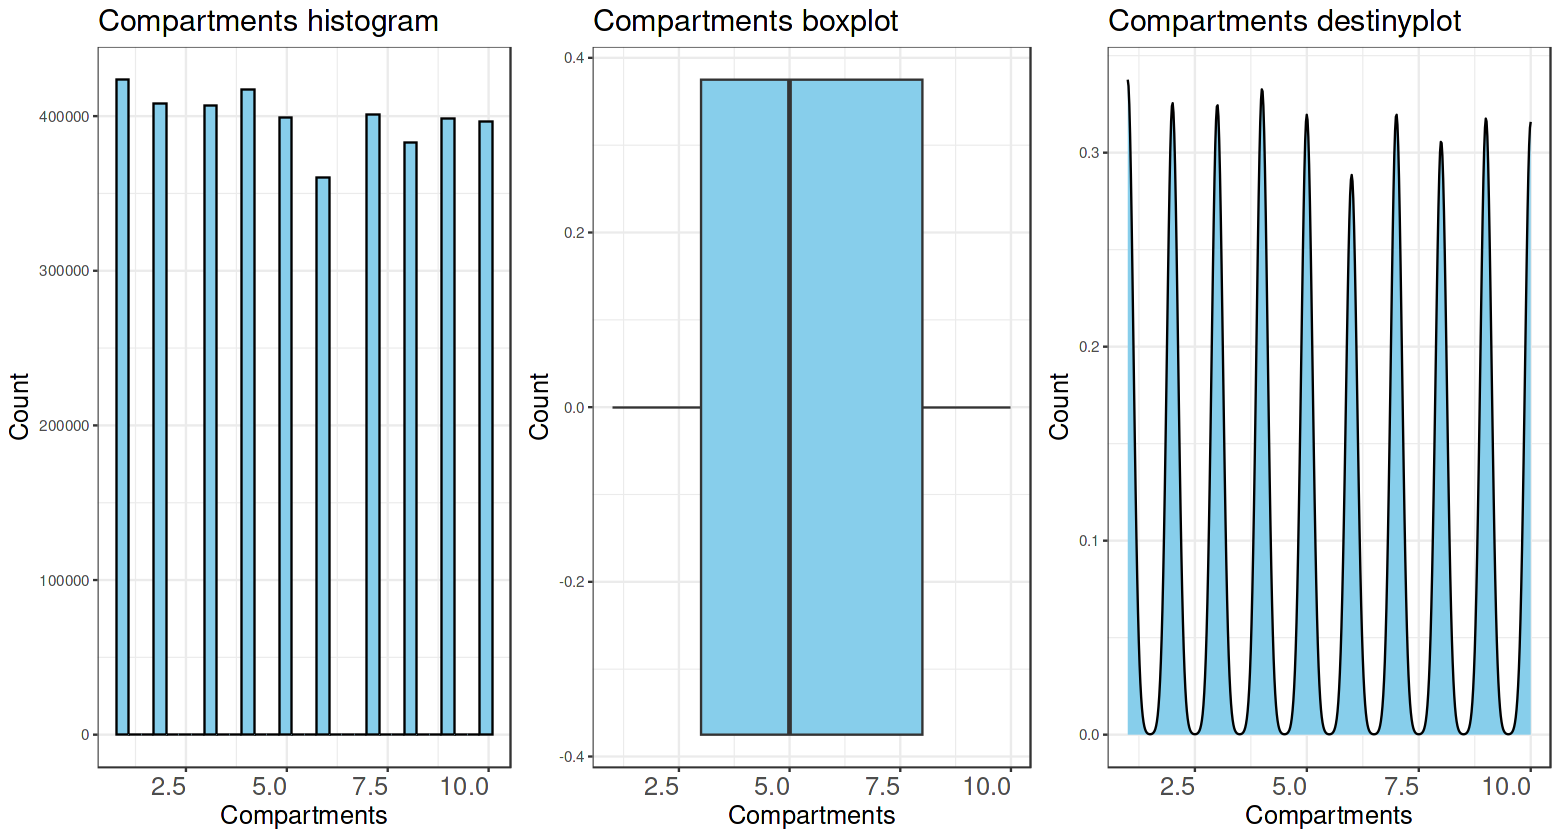

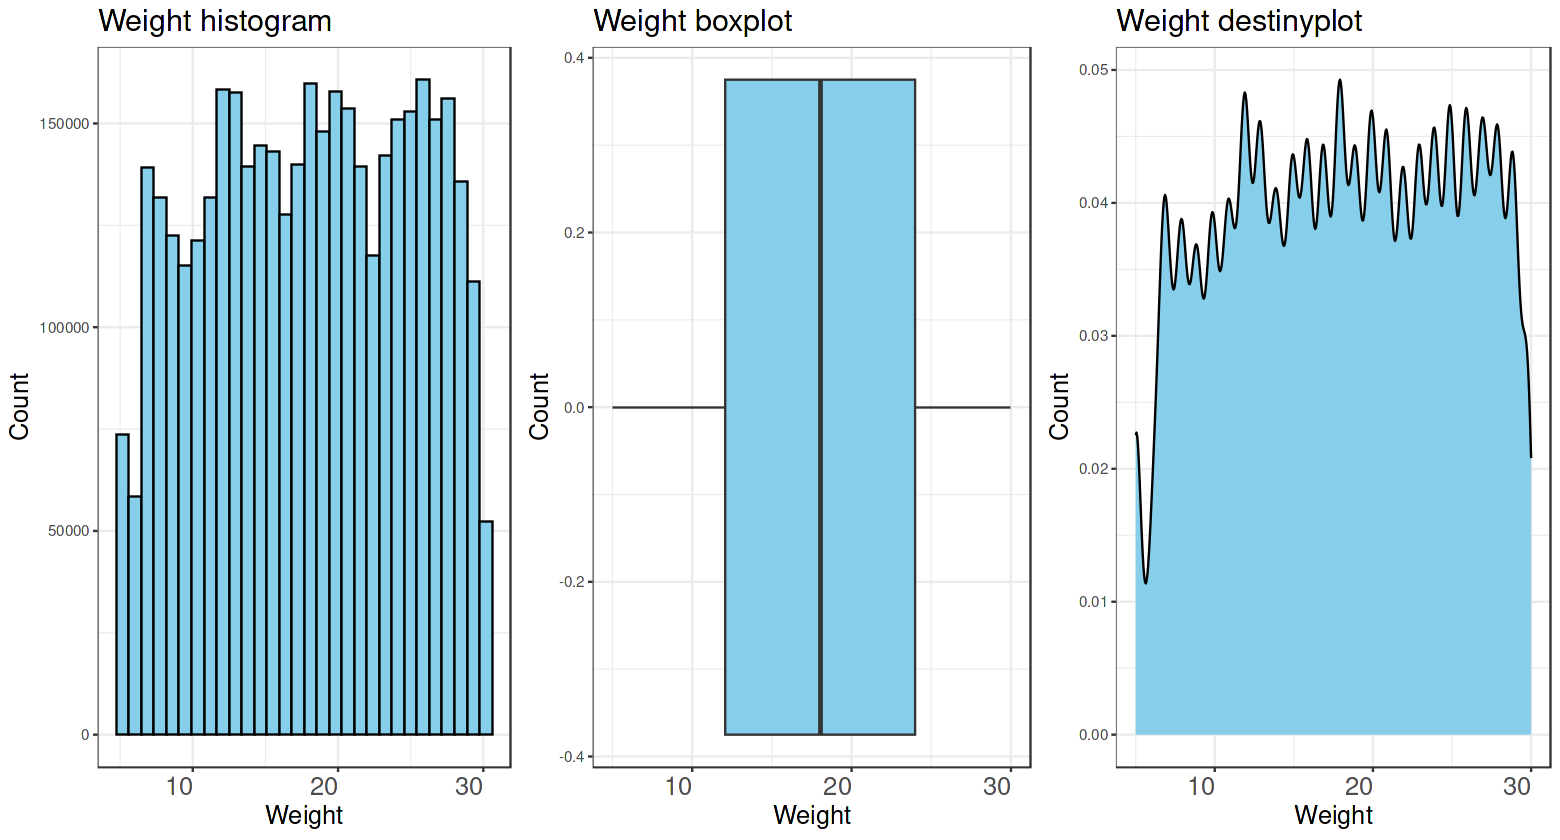

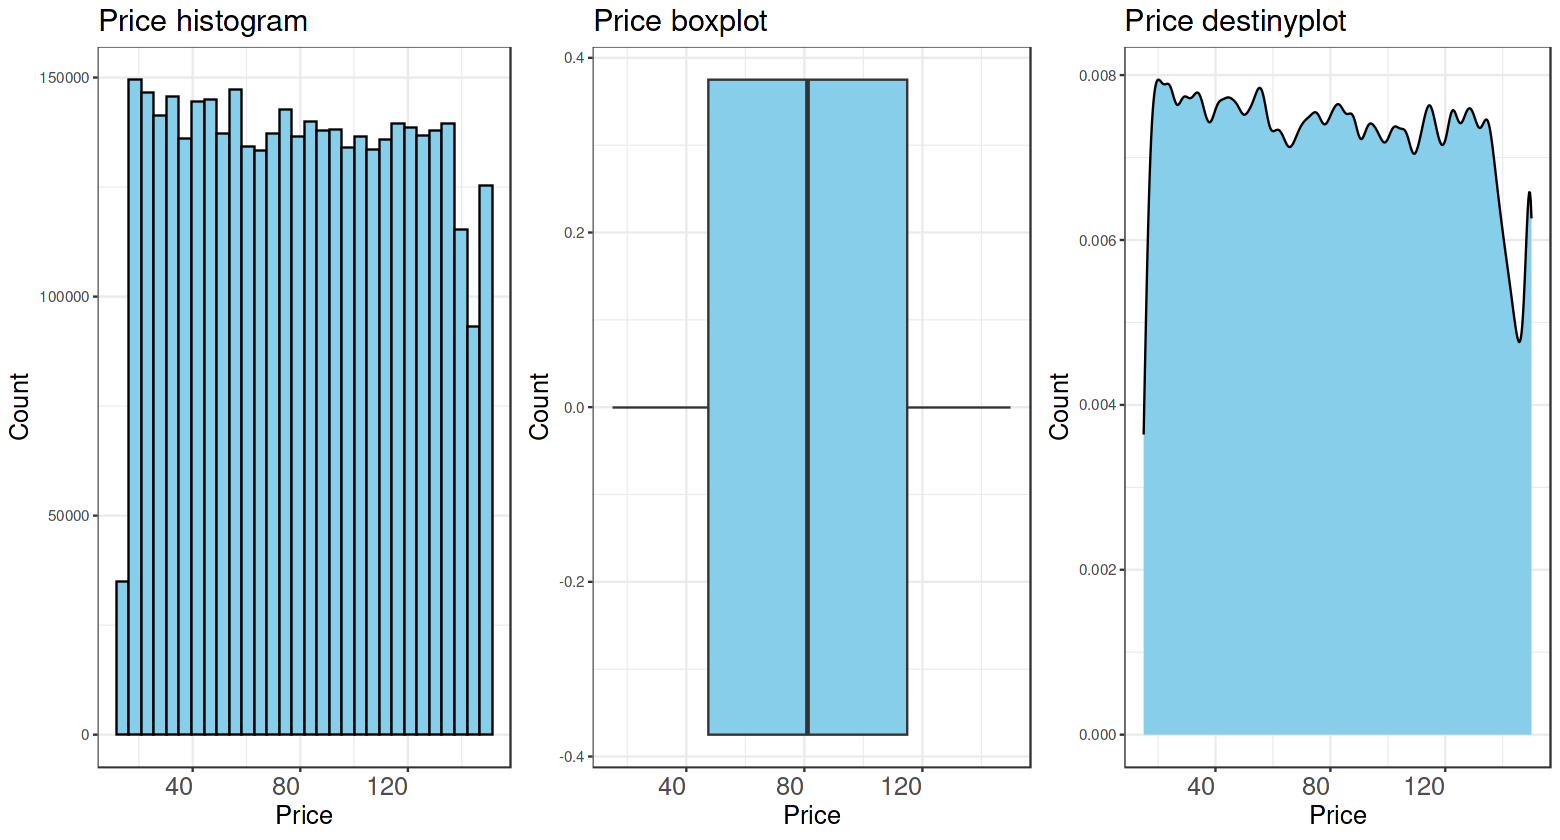

In [231]:
options(repr.plot.width = 13.0, repr.plot.height = 7.0)

for(i in num_cols){
    a <- ggplot(train) + geom_histogram(aes(x= train[,i]), fill = 'skyblue', col = 'black', position = 'dodge', bins= 30) + 
            labs(title = paste0(names(train[i]),' histogram'), x = names(train[i]), y = 'Count') + 
            theme_bw() +
            theme(axis.title = element_text(size=15),
            axis.text.x = element_text(size = 15, hjust=1),
            title = element_text(size=15)
            )
    
    b <- ggplot(train) + geom_boxplot(aes(x= train[,i]), fill = 'skyblue') + 
            labs(title = paste0(names(train[i]),' boxplot'), x = names(train[i]), y = 'Count') + 
            theme_bw() +
            theme(axis.title = element_text(size=15),
            axis.text.x = element_text(size = 15, hjust=1),
            title = element_text(size=15)
            ) 

    c <- ggplot(train) + geom_density(aes(x= train[,i]), fill = 'skyblue') + 
            labs(title = paste0(names(train[i]),' destinyplot'), x = names(train[i]), y = 'Count') + 
            theme_bw() +
            theme(axis.title = element_text(size=15),
            axis.text.x = element_text(size = 15, hjust=1),
            title = element_text(size=15)
            ) 
    
    grid.arrange(a,b ,c, ncol = 3)    
}

--------

## **CountPlot**

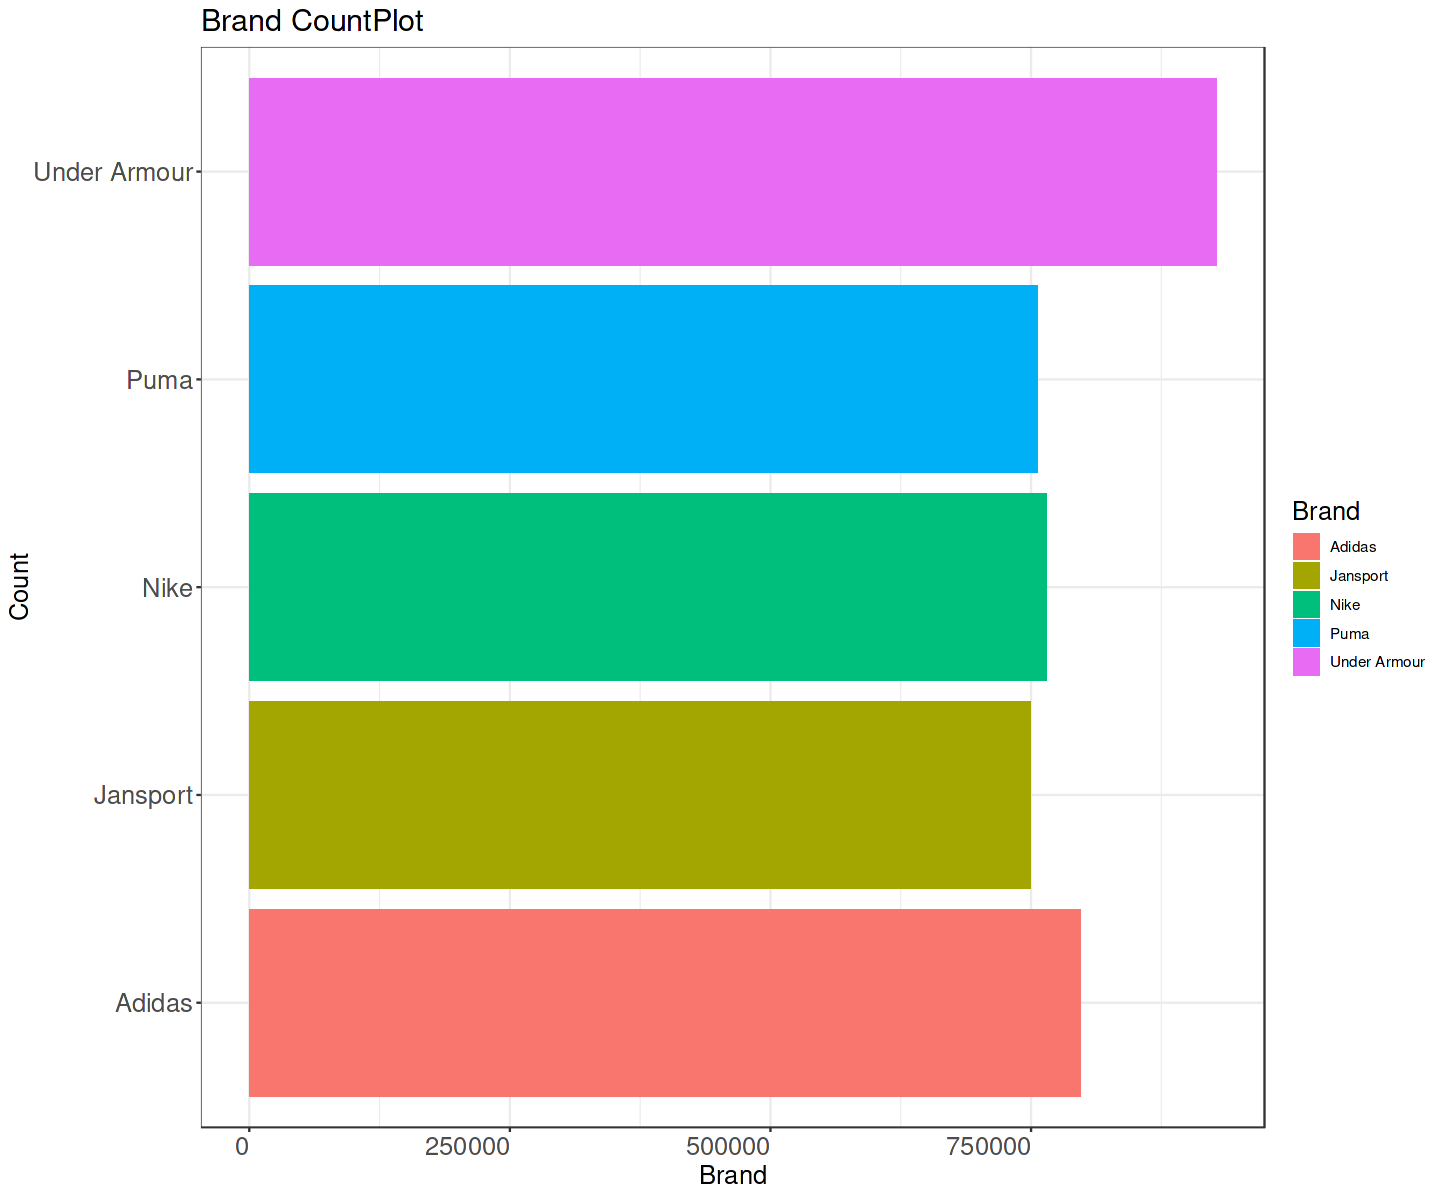

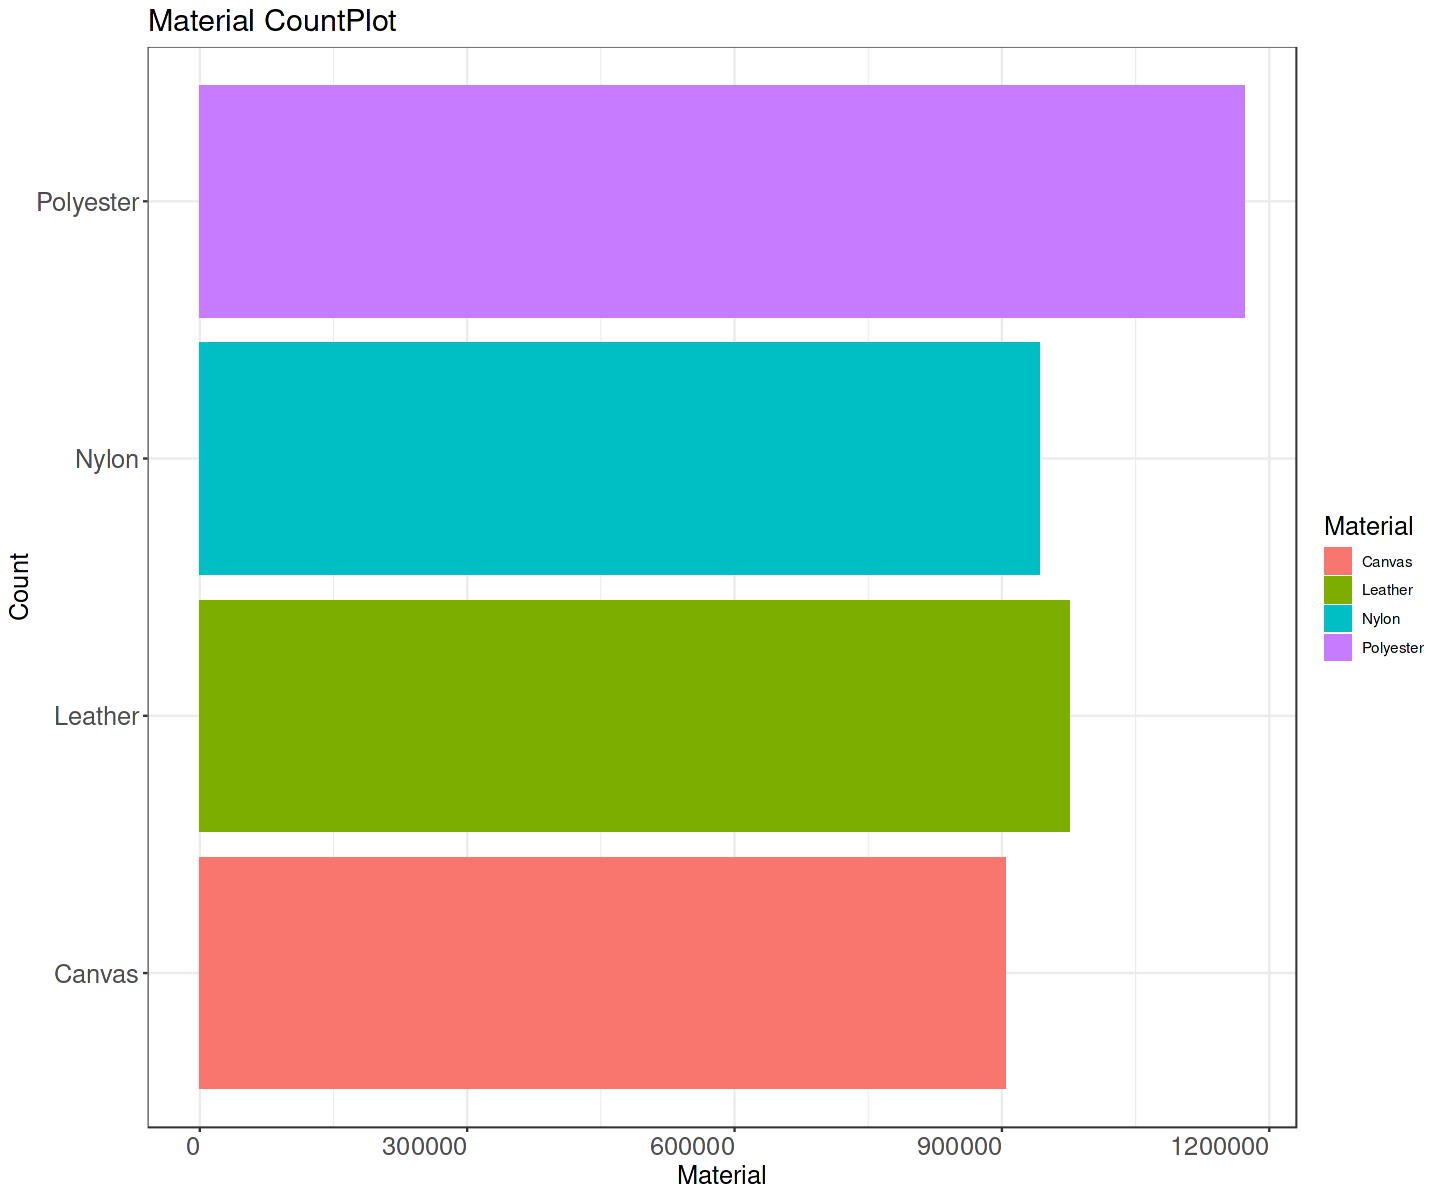

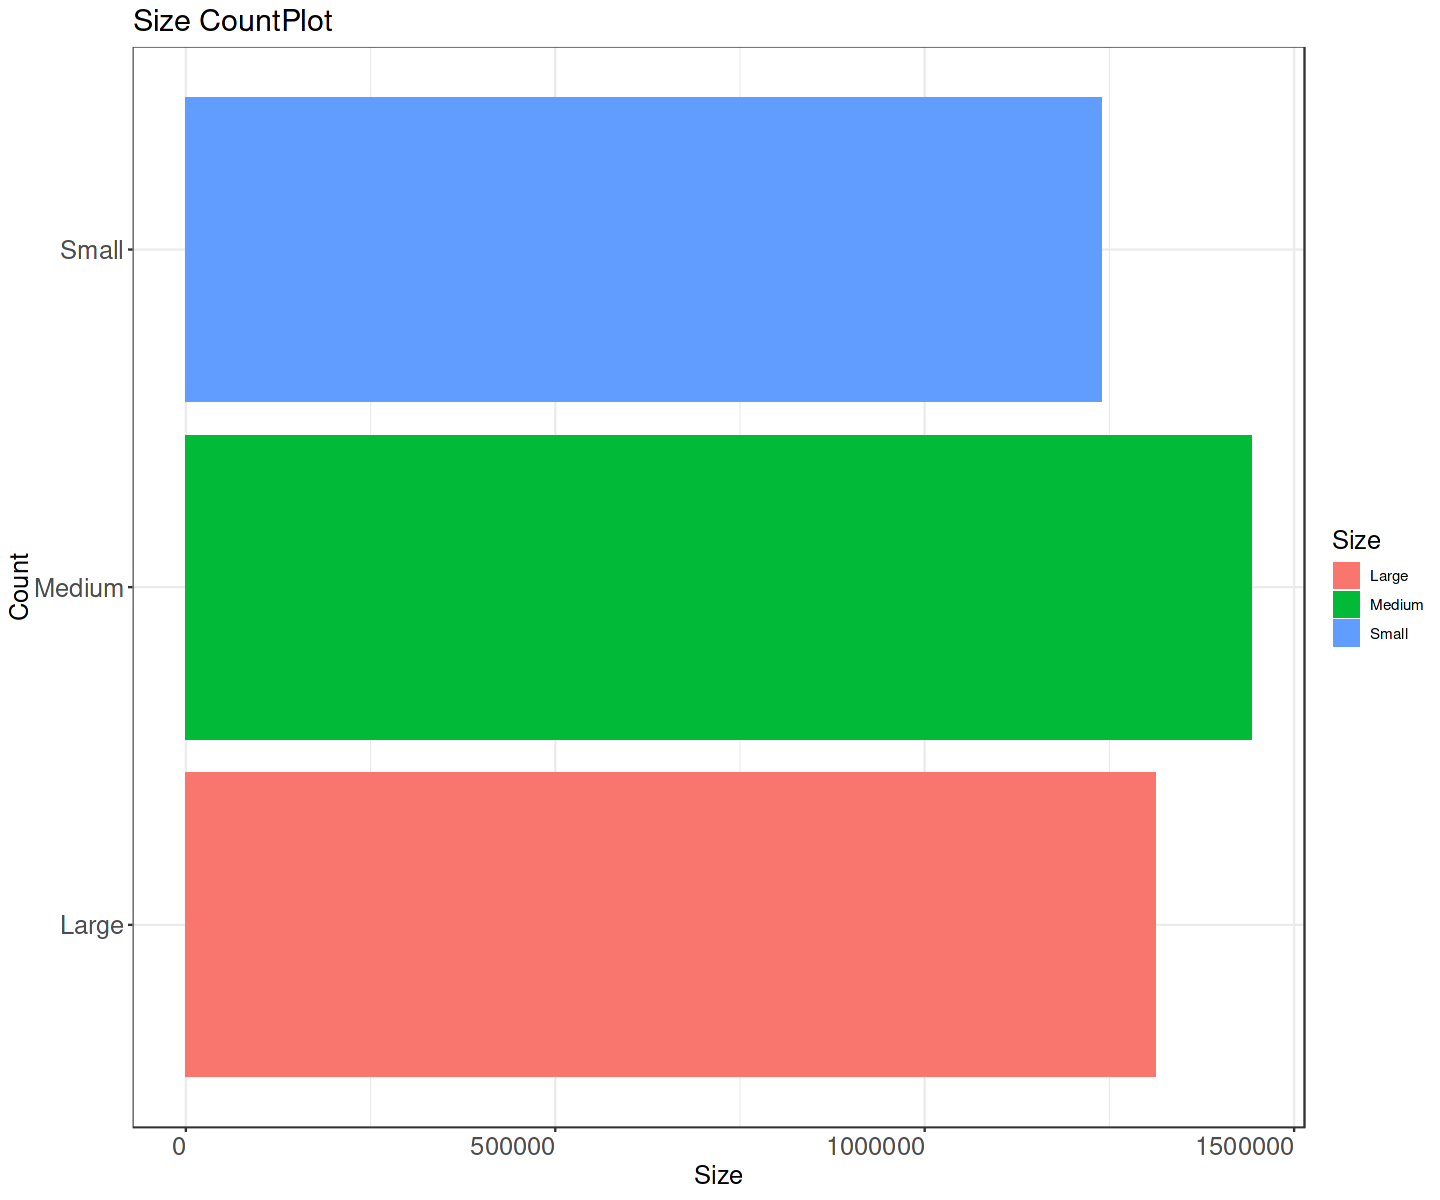

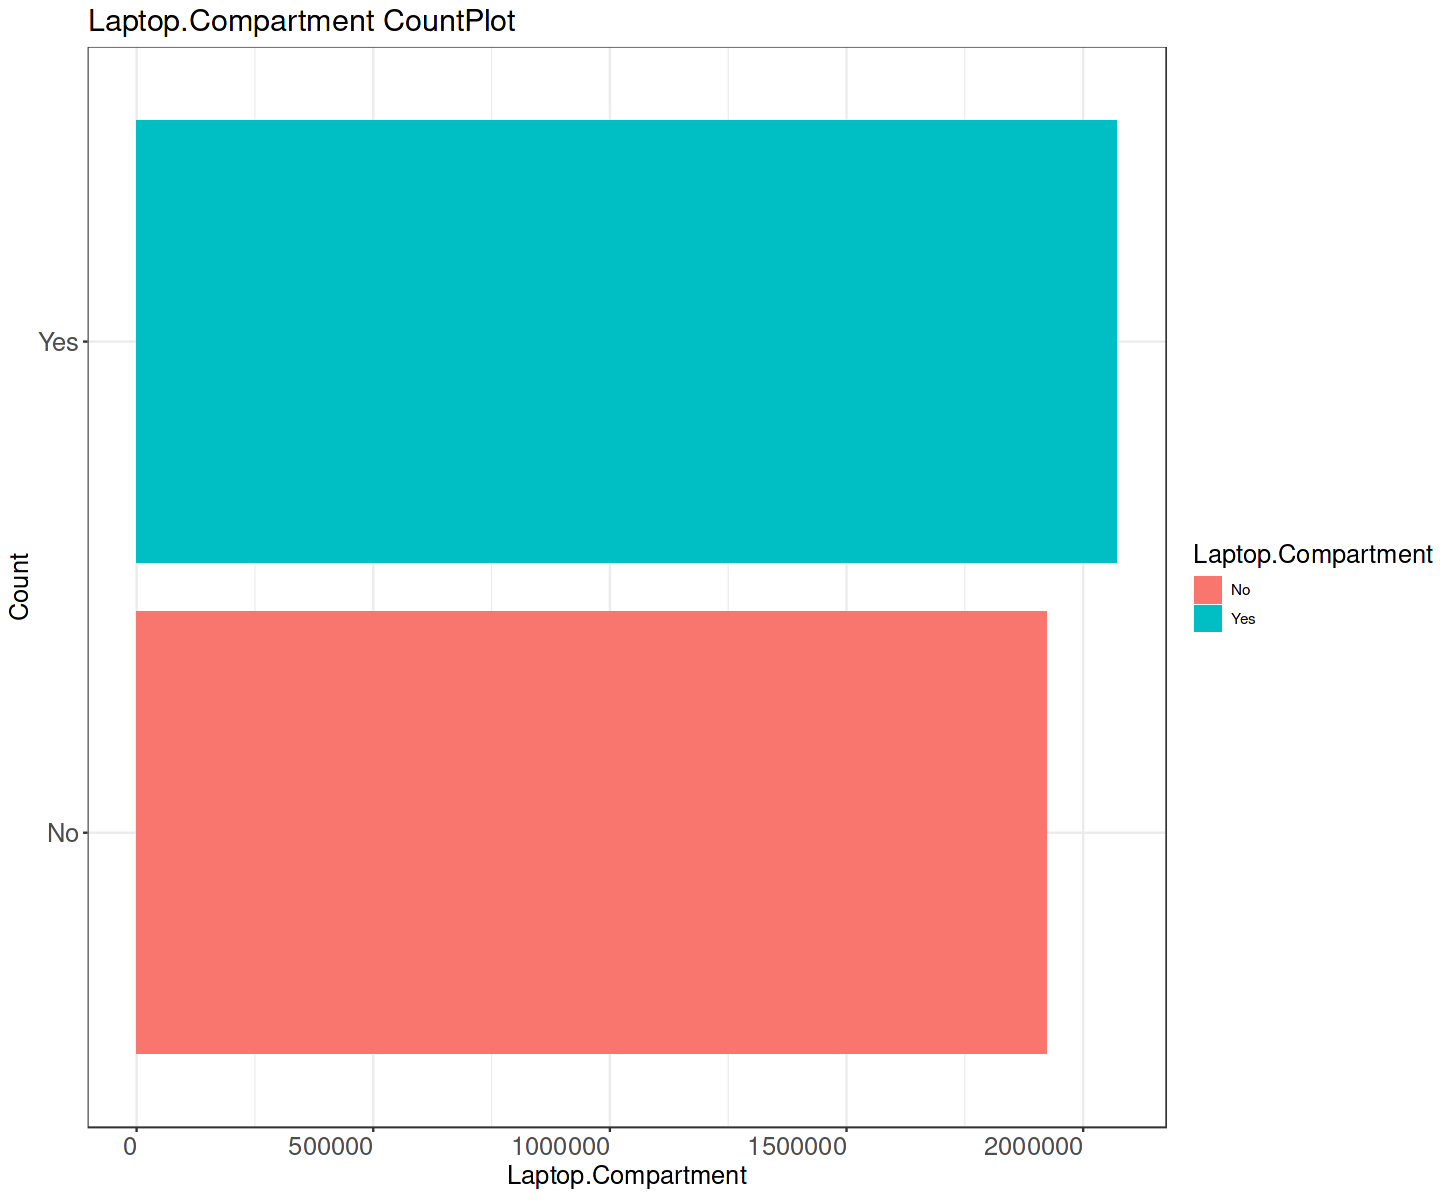

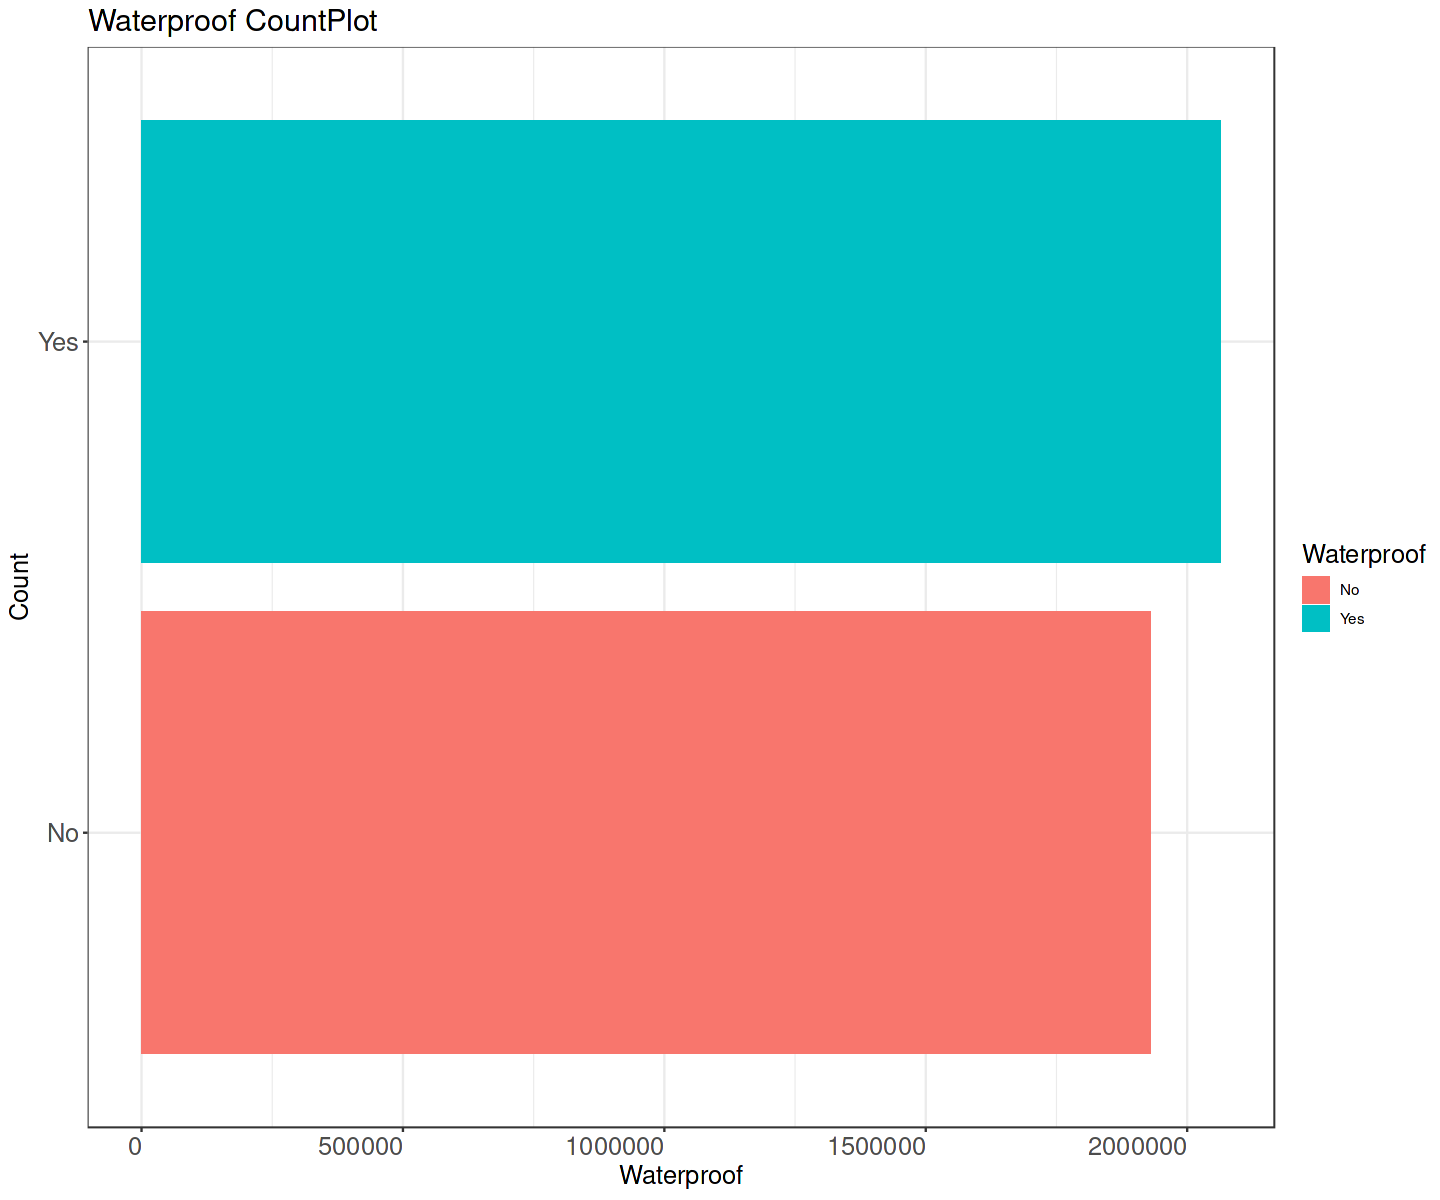

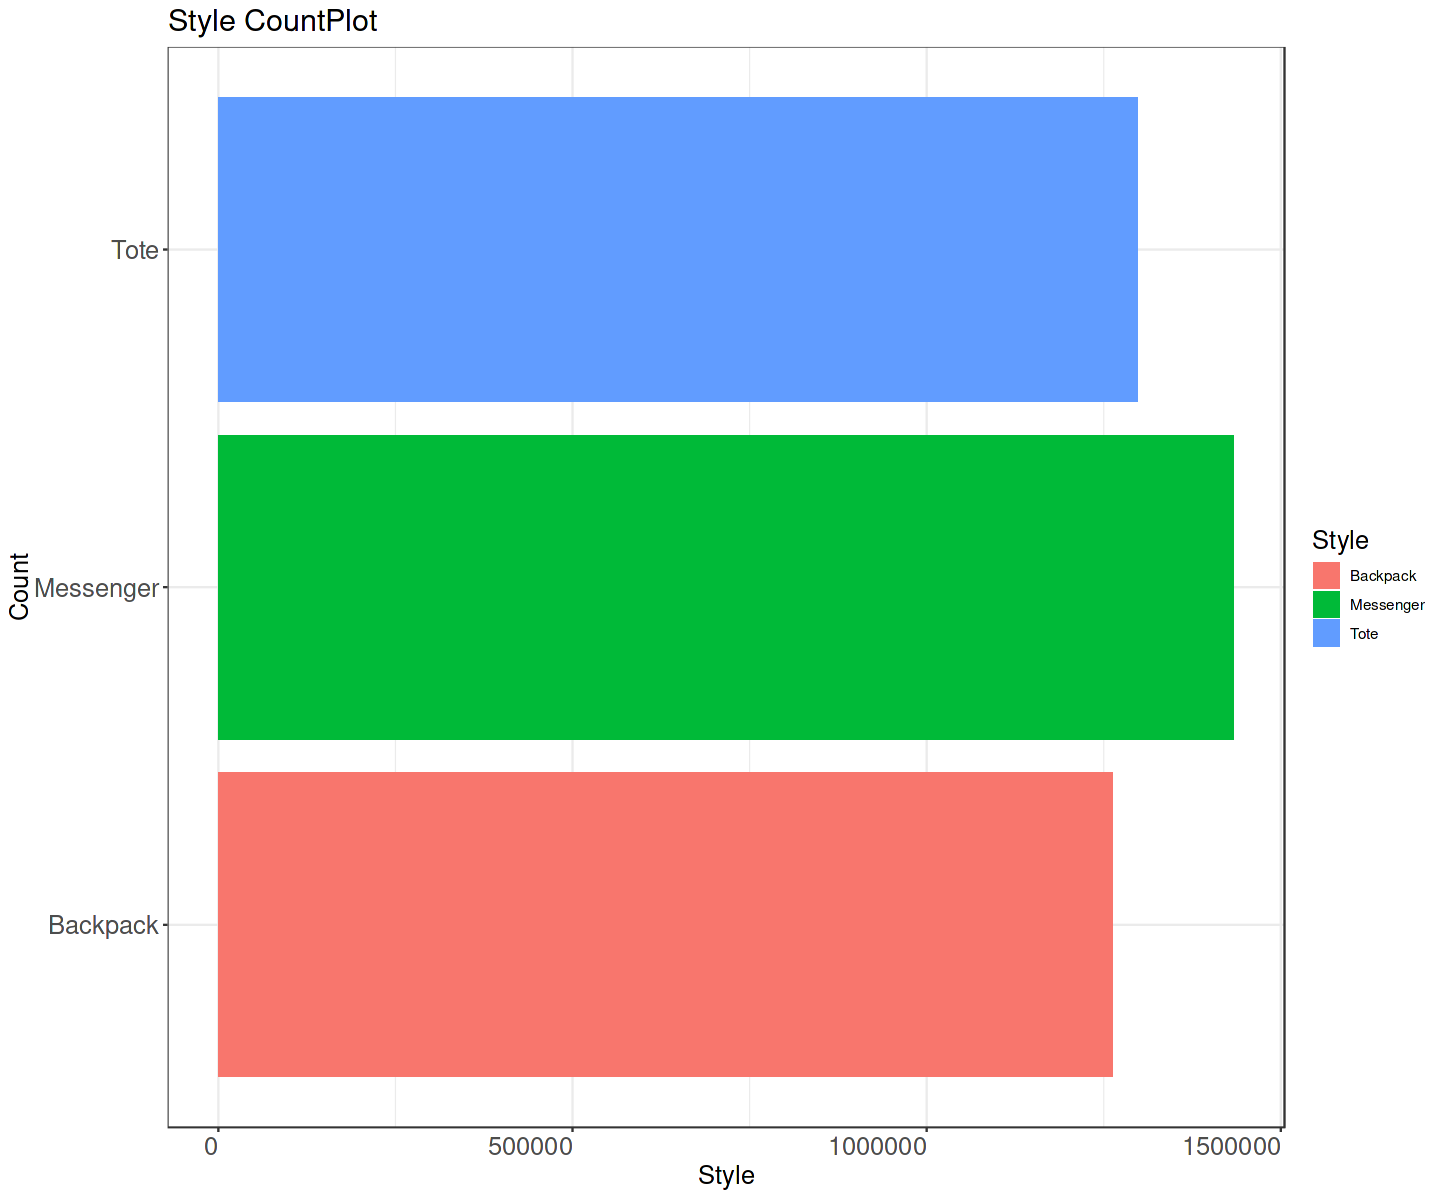

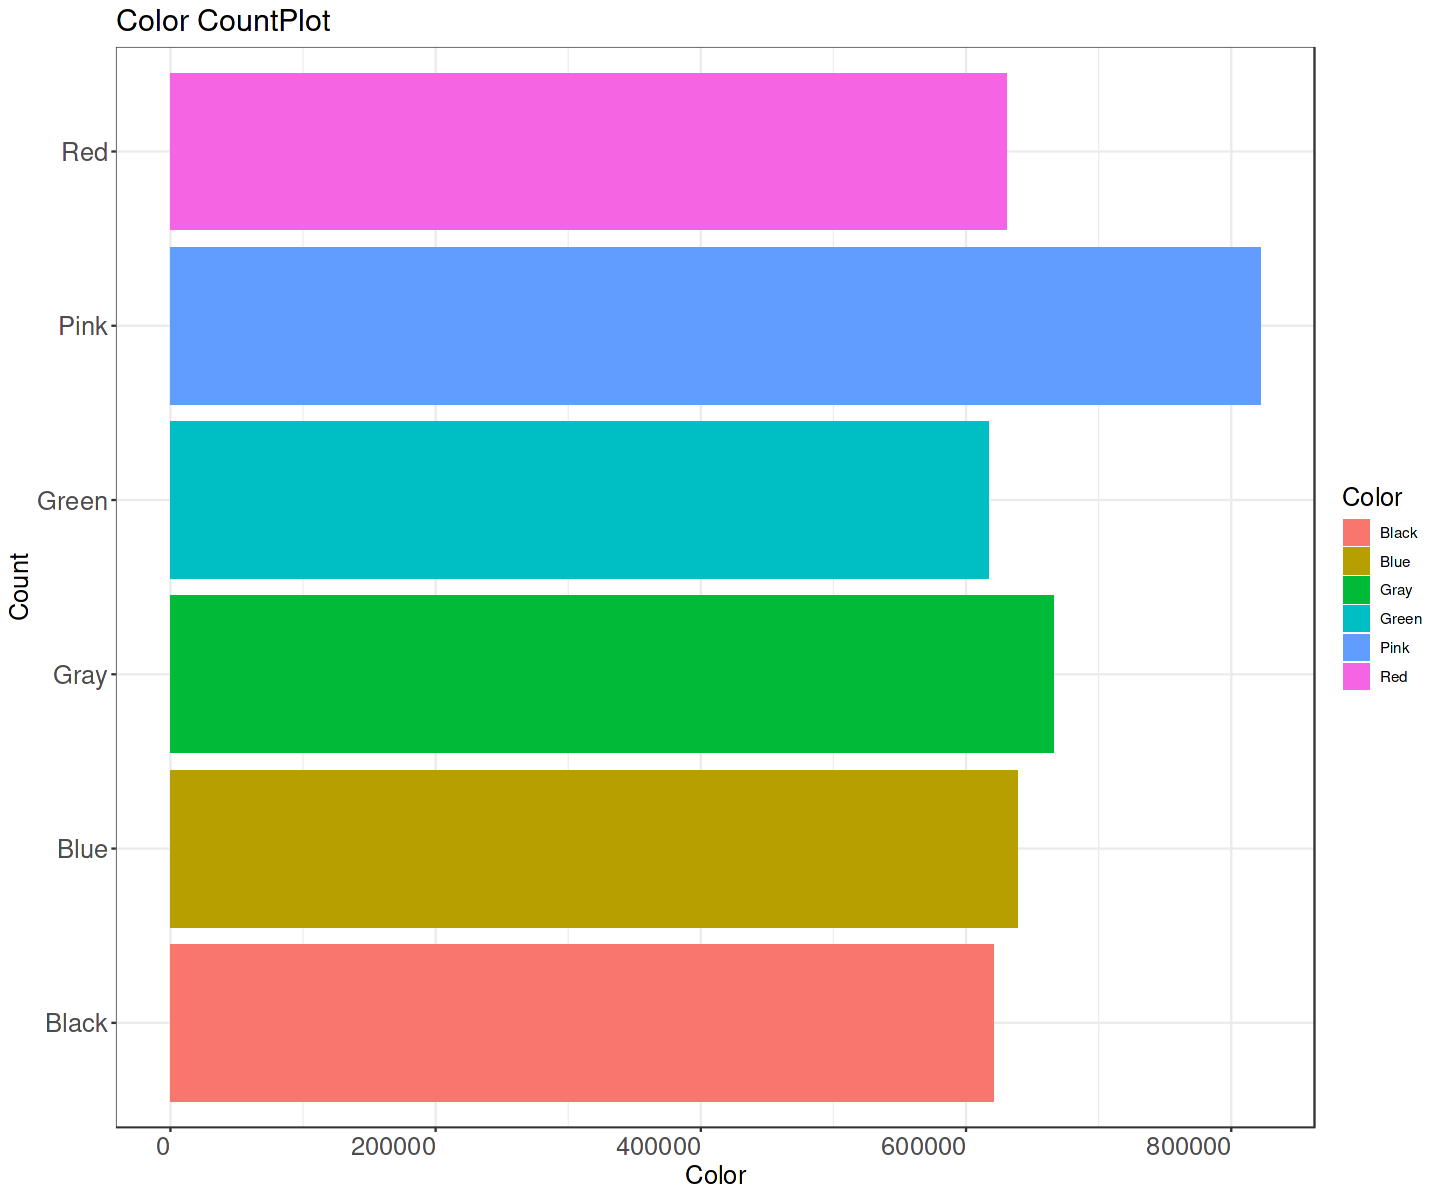

In [232]:
options(repr.plot.width = 12.0, repr.plot.height = 10.0)

for(i in cat_cols){
    a <- ggplot(train) + geom_bar(aes(y = train[,i], fill = train[,i])) + 
            labs(title = paste0(names(train[i]),' CountPlot'), x = names(train[i]), y = 'Count', fill = i ) + 
            theme_bw() +
            theme(axis.title = element_text(size=15),
            axis.text.x = element_text(size = 15, hjust=1),
            axis.text.y = element_text(size = 15, hjust=1)      ,
            title = element_text(size=15)
            )
    grid.arrange(a, ncol = 1)  
}

# **3. Modeling**

**The models to be used are as follows.**
1. Extreme Gradient Boosting.
2. Light Gradient Boosting Machine.

--------

In [233]:
library(caret)
library(Metrics)

## **Train Test Split**

In [234]:
split <- initial_split(train, prop = 0.8)
train_data <- training(split)
test_data <- testing(split)

## **Recipe**

In [235]:
set.seed(123)

rec <- recipe(Price　~ ., data = train_data) %>%
　step_YeoJohnson(all_numeric_predictors()) %>% 
  step_normalize(all_numeric_predictors()) %>%
  step_dummy(all_nominal_predictors())%>%
　step_novel(all_nominal_predictors())%>%
  step_zv

rec



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 9



── Operations 

• Yeo-Johnson transformation on: all_numeric_predictors()

• Centering and scaling for: all_numeric_predictors()

• Dummy variables from: all_nominal_predictors()

• Novel factor level assignment for: all_nominal_predictors()

• Zero variance filter on: <none>



## **5-Fold**

In [236]:
set.seed(123)
folds <- 
    train_data %>%
    vfold_cv(v = 5, strata = Price)

## **eXtreme Gradient Boosting**

In [237]:
# Model
#xgb <-
#  boost_tree(
#    trees = tune(),
#    tree_depth = tune(),
#    learn_rate = tune(),
#    mtry = tune(),
#    min_n = tune(),
#    loss_reduction = tune()
#  ) %>%
#  set_engine(engine = "xgboost", ) %>%
#  set_mode(mode = "regression")

# Workflow
#xgb_wf <- workflow() %>%
#  add_recipe(rec) %>% 
#  add_model(xgb)

In [238]:
# params
#params <- xgb_wf %>%
#  extract_parameter_set_dials() %>%
#  update(
#    trees = trees(range = c(200, 1500)),
#    mtry = mtry(range = c(5, 20)),
#    min_n = min_n(range = c(10, 90)),
#    tree_depth = tree_depth(range = c(11, 20)),
#   learn_rate = learn_rate(range = c(-2,3))
# ) %>%
#  finalize(train_data)

#Controol
#xgb_ctrl <- control_grid(verbose = TRUE,
#                         save_pred = TRUE,
#                         save_workflow = TRUE)

#Tune
#xgb_tune <- tune_grid(
#  xgb_wf,
#  resamples = folds,
#  grid = 4,
#  metrics = metric_set(rsq),
#  param_info = params
#)

In [239]:
# Select the best
#best_xgb <- select_best(xgb_tune, metric = "rsq")
#final_xgb <- finalize_workflow(xgb_wf, best_xgb)
#
# Fit
#xgb_fit <- final_xgb %>% 
#  fit(data = train_data)
#
# Predict
#xgb_pred <- xgb_fit %>% 
#  predict(new_data = test_data)

## **Light Gradient Boosting Machine**

In [240]:
# Model
library(bonsai)

lgbm <-  boost_tree(
    trees = tune(),
    tree_depth = tune(),
    learn_rate = tune(),
    mtry = tune(),
    min_n = tune(),
    loss_reduction = tune()
  ) %>%
  set_engine(engine = "lightgbm",
             is_unbalance = TRUE,
             num_leaves = tune(),
             nthread  = future::availableCores()
) %>%
  set_mode(mode = "regression")

# Workflow
lgbm_wf <- workflow() %>%
  add_recipe(rec) %>% 
  add_model(lgbm)

In [241]:
# params
params <- lgbm_wf %>%
  extract_parameter_set_dials() %>%
  update(
    trees = trees(range = c(200, 1500)),
    mtry = mtry(range = c(5, 20)),
    min_n = min_n(range = c(10, 90)),
    tree_depth = tree_depth(range = c(11, 20)),
    learn_rate = learn_rate(range = c(-2,3)),
    num_leaves = num_leaves(range = c(100, 300))
  ) %>%
  finalize(train_data)

#Controol
lgbm_ctrl <- control_grid(verbose = TRUE,
                         save_pred = TRUE,
                         save_workflow = TRUE)

#Tune
lgbm_tune <- tune_grid(
  lgbm_wf,
  resamples = folds,
  grid = 4,
  control = lgbm_ctrl,
  metrics = metric_set(rsq),
  param_info = params
)

i Fold1: preprocessor 1/1

✓ Fold1: preprocessor 1/1

i Fold1: preprocessor 1/1, model 1/4

✓ Fold1: preprocessor 1/1, model 1/4

i Fold1: preprocessor 1/1, model 1/4 (extracts)

i Fold1: preprocessor 1/1, model 1/4 (predictions)

i Fold1: preprocessor 1/1, model 2/4

✓ Fold1: preprocessor 1/1, model 2/4

i Fold1: preprocessor 1/1, model 2/4 (extracts)

i Fold1: preprocessor 1/1, model 2/4 (predictions)

i Fold1: preprocessor 1/1, model 3/4

✓ Fold1: preprocessor 1/1, model 3/4

i Fold1: preprocessor 1/1, model 3/4 (extracts)

i Fold1: preprocessor 1/1, model 3/4 (predictions)

i Fold1: preprocessor 1/1, model 4/4

✓ Fold1: preprocessor 1/1, model 4/4

i Fold1: preprocessor 1/1, model 4/4 (extracts)

i Fold1: preprocessor 1/1, model 4/4 (predictions)

i Fold2: preprocessor 1/1

✓ Fold2: preprocessor 1/1

i Fold2: preprocessor 1/1, model 1/4

✓ Fold2: preprocessor 1/1, model 1/4

i Fold2: preprocessor 1/1, model 1/4 (extracts)

i Fold2: preprocessor 1/1, model 1/4 (predictions)

i Fold2

In [242]:
# Select the best
best_lgbm <- select_best(lgbm_tune, metric = "rsq")
final_lgbm <- finalize_workflow(lgbm_wf, best_lgbm)

# Fit
lgbm_fit <- final_lgbm %>% 
  fit(data = train_data)

# Predict
lgbm_pred <- predict(lgbm_fit, new_data = test_data, type='numeric')

In [243]:
lgbm_mse <- mse(test_data$Price , lgbm_pred$.pred)
lgbm_rmse <- rmse(test_data$Price ,lgbm_pred$.pred)
lgbm_mae <- mae(test_data$Price ,lgbm_pred$.pred)

In [244]:
options(scipen = 100)
lgbm_score <- data.frame(Indicators = c('MSE','RMSE','MAE') , Score = c(lgbm_mse,lgbm_rmse ,lgbm_mae))
lgbm_score

Indicators,Score
<chr>,<dbl>
MSE,1515.45974
RMSE,38.92891
MAE,33.67491


In [246]:
pred <- predict(lgbm_fit, new_data = test, type='numeric')

In [249]:
submission <- data.frame(id = test$id, Price = pred$.pred)

In [250]:
head(submission)

,id,Price
,<int>,<dbl>
1,300000,81.01797
2,300001,82.56874
3,300002,82.72771
4,300003,80.51593
5,300004,77.27911
6,300005,82.28648


In [251]:
write.csv(submission,"submission.csv",quote = FALSE, row.names = FALSE)